In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import tensorflow as tf
import random 
from datetime import datetime
import pandas as pd
import os 

import sys
sys.path.append('/glade/work/kjmayer/research/catalyst/ENSOvsMJO/utils/')
# sys.path.append('/glade/u/home/wchapman/ENSOvsMJO/utils/')
from exp_hp import get_hp
from trainGordon_utils import subset, build_model, fullmodel, scheduler, plot_results, adjust_spines
from dataprep_utils import get_testing
sys.path.append('/glade/work/kjmayer/research/catalyst/ENSOvsMJO/interpret/')
from Gordon_interp import getoutputvecs

import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rc('text',usetex=True)
plt.rcParams['font.family']='sans-serif'
plt.rcParams['font.sans-serif']=['Verdana']
plt.rcParams.update({'font.size': 15})
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spine:
            spine.set_position(('outward', 5))
        else:
            spine.set_color('none')
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
            ax.xaxis.set_ticks([])
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi'] = 150
dpiFig = 300.

2023-10-04 11:24:05.132025: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-04 11:24:06.643056: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
MODEL_DIR = '/glade/scratch/wchapman/ENSOmjo_ML_models/saved_models/'
EXP_NAME = 'default'
hps = get_hp(EXP_NAME)
# variables:
DROPOUT_RATE = hps['DROPOUT_RATE']

MODELNAME1 = 'ENSO'
RIDGE1 = hps['RIDGE1']
HIDDENS1 = hps['HIDDENS1']

MODELNAME2 = 'MJO'
RIDGE2 = hps['RIDGE2']
HIDDENS2 = hps['HIDDENS2']

BATCH_SIZE = hps['BATCH_SIZE']
N_EPOCHS = 10000
PATIENCE = hps['PATIENCE'] # number of epochs of no "improvement" before training is stopped
LR = hps['LR'] # learning rate


LEADS = np.arange(7,31) #np.arange(7,31)
AVGS = np.arange(7,32)
SEEDS = np.arange(1,6)

ddir_load = '/glade/scratch/kjmayer/DATA/ENSOvsMJO/data/'

## z500 averaging window: 7 day & 30 day, all leads

In [3]:
avg_inputweight = np.zeros(shape=(len(LEADS),2,9,2)) # lead, model, mjo-enso options, neg-pos

for l,lead in enumerate(LEADS):
    print('LEAD: '+str(lead))
    
    for a,avg in enumerate(AVGS[-2:-1]):# 30
        print('AVG: '+str(avg))
        X1test, X2test, Ytest = get_testing(N_z500runmean=avg,LEAD=lead)
        
        # input*weights output
        finame_rawpred = 'model1_rawpred_LEAD_'+str(lead)+'_AVG_'+str(avg)+'__00001-00005.npy'
        model1_rawpreds = np.load(ddir_load+finame_rawpred)
        finame_rawpred = 'model2_rawpred_LEAD_'+str(lead)+'_AVG_'+str(avg)+'__00001-00005.npy'
        model2_rawpreds = np.load(ddir_load+finame_rawpred)
        # finame_rawpred = 'model_rawpred_LEAD_'+str(lead)+'_AVG_'+str(avg)+'__00001-00005.npy'
        # model_rawpreds = np.load(ddir_load+finame_rawpred) # raw preds after softmax
        # sftmx = tf.keras.layers.Softmax()
        # sftmx(model1_rawpreds + model2_rawpreds).numpy() == model_rawpreds #True
        model_rawpreds = model1_rawpreds + model2_rawpreds
        
        # model1_rawpreds_norm = model1_rawpreds/(model_rawpreds)
        # model2_rawpreds_norm = model2_rawpreds/(model_rawpreds)
        
        # MJO amplitude
        RMM_amp = np.sqrt((X2test[:,0])**2 + (X2test[:,1])**2)
        iactive = RMM_amp >= 1
        # MJO Phase
        RMM_ph = np.arctan2(X2test[:,1],X2test[:,0]) * 180./(4.*np.arctan(1.0))
        RMM_ph[np.where(RMM_ph<0)] = RMM_ph[np.where(RMM_ph<0)] + 360
        iph23 = (RMM_ph >= 225) & (RMM_ph <270) | (RMM_ph >= 270) & (RMM_ph <315)
        iph67 = (RMM_ph >= 45) & (RMM_ph < 90) | (RMM_ph >= 90) & (RMM_ph <135)
        
        # ENSO Index
        ONI = X1test[:,0]
        inino = ONI >= 1
        inina = ONI <= -1
        ineut = (ONI < 1) & (ONI > -1)
        
        
        # ----- LOCATION OF MJO/ENSO ACTIVITY -----
        # El Nino & inactive MJO
        inino_noMJO = inino & ~iactive
        # El Nino & ph 2/3
        inino_ph23 = inino & iactive & iph23
        # El Nino & ph 6/7
        inino_ph67 = inino & iactive & iph67
        
        # La Nina & inactive MJO
        inina_noMJO = inina & ~iactive
        # La Nina & ph 2/3
        inina_ph23 = inina & iactive & iph23
        # La Nina & ph 6/7
        inina_ph67 = inina & iactive & iph67
        
        # Neutral & inactive MJO
        ineut_noMJO = ineut & ~iactive
        # Neutral & ph 2/3
        ineut_ph23 = ineut & iactive & iph23
        # Neurtral & ph 6/7
        ineut_ph67 = ineut & iactive & iph67
        
        
        # ----- SUBSET MODEL PREDICTIONS BY MJO/ENSO ACTIVITY (mean across seeds & predictions) -----
        # El Nino 
        #     inactive MJO
        model1_nino_noMJO = np.mean(model1_rawpreds[:,inino_noMJO],axis=(0,1))
        model2_nino_noMJO = np.mean(model2_rawpreds[:,inino_noMJO],axis=(0,1))
        #     ph 2/3
        model1_nino_ph23 = np.mean(model1_rawpreds[:,inino_ph23],axis=(0,1))
        model2_nino_ph23 = np.mean(model2_rawpreds[:,inino_ph23],axis=(0,1))
        #     ph 6/7
        model1_nino_ph67 = np.mean(model1_rawpreds[:,inino_ph67],axis=(0,1))
        model2_nino_ph67 = np.mean(model2_rawpreds[:,inino_ph67],axis=(0,1))
        
        
        # La Nina 
        #    inactive MJO
        model1_nina_noMJO = np.mean(model1_rawpreds[:,inina_noMJO],axis=(0,1))
        model2_nina_noMJO = np.mean(model2_rawpreds[:,inina_noMJO],axis=(0,1))
        #    ph 2/3
        model1_nina_ph23 = np.mean(model1_rawpreds[:,inina_ph23],axis=(0,1))
        model2_nina_ph23 = np.mean(model2_rawpreds[:,inina_ph23],axis=(0,1))
        #    ph 6/7
        model1_nina_ph67 = np.mean(model1_rawpreds[:,inina_ph67],axis=(0,1))
        model2_nina_ph67 = np.mean(model2_rawpreds[:,inina_ph67],axis=(0,1))
        
        
        # Neutral 
        #    inactive MJO
        model1_neut_noMJO = np.mean(model1_rawpreds[:,ineut_noMJO],axis=(0,1)) 
        model2_neut_noMJO = np.mean(model2_rawpreds[:,ineut_noMJO],axis=(0,1))
        #    ph 2/3
        model1_neut_ph23 = np.mean(model1_rawpreds[:,ineut_ph23],axis=(0,1)) 
        model2_neut_ph23 = np.mean(model2_rawpreds[:,ineut_ph23],axis=(0,1)) 
        #    ph 6/7
        model1_neut_ph67 = np.mean(model1_rawpreds[:,ineut_ph67],axis=(0,1)) 
        model2_neut_ph67 = np.mean(model2_rawpreds[:,ineut_ph67],axis=(0,1)) 
        
        
        avg_inputweight[l,0] = model1_nino_noMJO, model1_nino_ph23, model1_nino_ph67, model1_nina_noMJO, model1_nina_ph23, model1_nina_ph67, model1_neut_noMJO, model1_neut_ph23, model1_neut_ph67
        avg_inputweight[l,1] = model2_nino_noMJO, model2_nino_ph23, model2_nino_ph67, model2_nina_noMJO, model2_nina_ph23, model2_nina_ph67, model2_neut_noMJO, model2_neut_ph23, model2_neut_ph67
        
        
ddir_save = '/glade/work/kjmayer/research/catalyst/ENSOvsMJO/data/'
np.save(ddir_save+'model_inputweight_ENSOMJOsubset__LEAD_7-30_AVG_30__avg00001-00005.npy',avg_inputweight)

LEAD: 7
AVG: 30
LEAD: 8
AVG: 30
LEAD: 9
AVG: 30
LEAD: 10
AVG: 30
LEAD: 11
AVG: 30
LEAD: 12
AVG: 30
LEAD: 13
AVG: 30
LEAD: 14
AVG: 30
LEAD: 15
AVG: 30
LEAD: 16
AVG: 30
LEAD: 17
AVG: 30
LEAD: 18
AVG: 30
LEAD: 19
AVG: 30
LEAD: 20
AVG: 30
LEAD: 21
AVG: 30
LEAD: 22
AVG: 30
LEAD: 23
AVG: 30
LEAD: 24
AVG: 30
LEAD: 25
AVG: 30
LEAD: 26
AVG: 30
LEAD: 27
AVG: 30
LEAD: 28
AVG: 30
LEAD: 29
AVG: 30
LEAD: 30
AVG: 30


## Load & plot data:

In [5]:
ddir_load = '/glade/work/kjmayer/research/catalyst/ENSOvsMJO/data/'
avg_inputweight = np.load(ddir_load+'model_inputweight_ENSOMJOsubset__LEAD_7-30_AVG_30__avg00001-00005.npy')

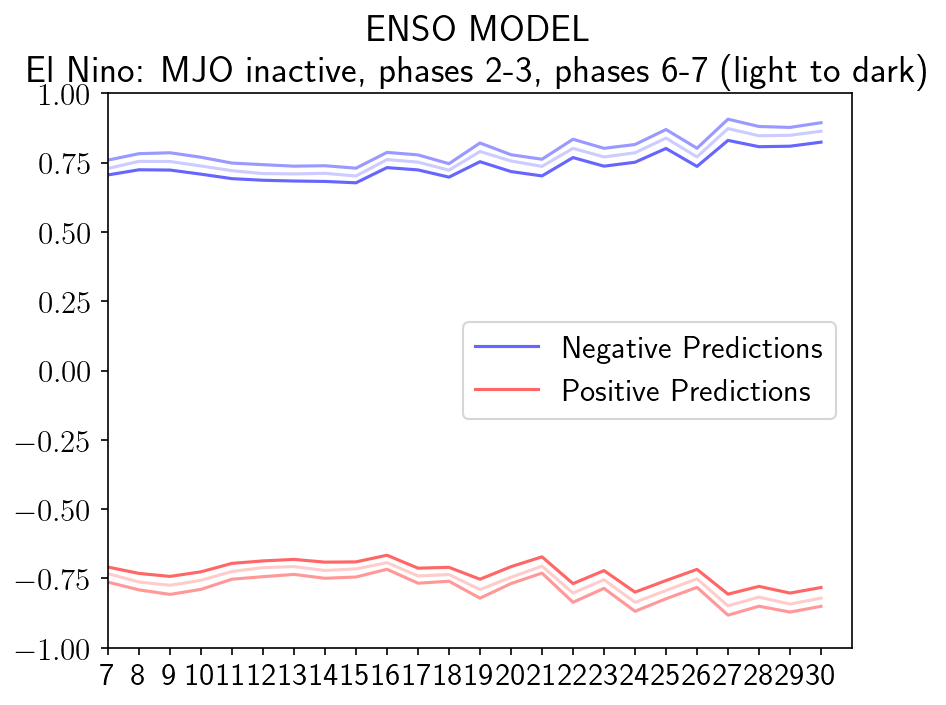

In [6]:
# El Nino negative predictions across leads
plt.plot(avg_inputweight[:,0,0,0],color='blue',alpha=0.2)
plt.plot(avg_inputweight[:,0,1,0],color='blue',alpha=0.4)
plt.plot(avg_inputweight[:,0,2,0],color='blue',alpha=0.6,label='Negative Predictions')

# El Nino positive predictions across leads
plt.plot(avg_inputweight[:,0,0,1],color='red',alpha=0.2)
plt.plot(avg_inputweight[:,0,1,1],color='red',alpha=0.4)
plt.plot(avg_inputweight[:,0,2,1],color='red',alpha=0.6,label='Positive Predictions')

plt.xlim(0,24)
plt.xticks(np.arange(0,24),np.arange(7,31))
plt.ylim(-1,1)
plt.legend()
plt.title('ENSO MODEL \n El Nino: MJO inactive, phases 2-3, phases 6-7 (light to dark)')
plt.show()

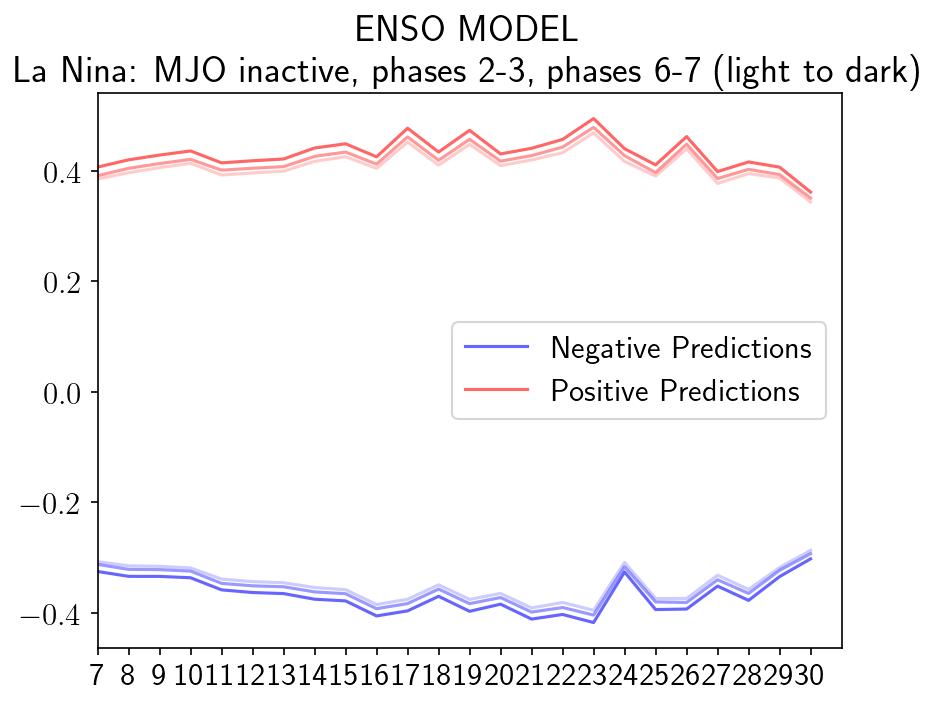

In [7]:
# La Nina negative predictions across leads
plt.plot(avg_inputweight[:,0,3,0],color='blue',alpha=0.2)
plt.plot(avg_inputweight[:,0,4,0],color='blue',alpha=0.4)
plt.plot(avg_inputweight[:,0,5,0],color='blue',alpha=0.6,label='Negative Predictions')

# La Nina positive predictions across leads
plt.plot(avg_inputweight[:,0,3,1],color='red',alpha=0.2)
plt.plot(avg_inputweight[:,0,4,1],color='red',alpha=0.4)
plt.plot(avg_inputweight[:,0,5,1],color='red',alpha=0.6,label='Positive Predictions')

plt.xlim(0,24)
plt.xticks(np.arange(0,24),np.arange(7,31))
plt.legend()
plt.title('ENSO MODEL \n La Nina: MJO inactive, phases 2-3, phases 6-7 (light to dark)')
plt.show()

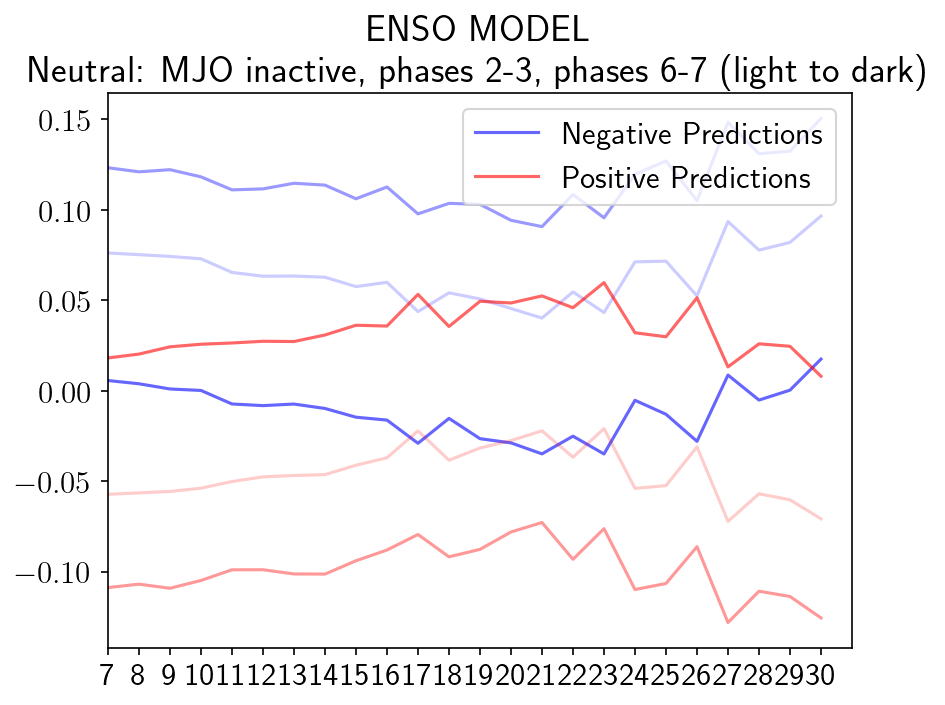

In [8]:
# Neutral negative predictions across leads
plt.plot(avg_inputweight[:,0,6,0],color='blue',alpha=0.2)
plt.plot(avg_inputweight[:,0,7,0],color='blue',alpha=0.4)
plt.plot(avg_inputweight[:,0,8,0],color='blue',alpha=0.6,label='Negative Predictions')

# Neutral positive predictions across leads
plt.plot(avg_inputweight[:,0,6,1],color='red',alpha=0.2)
plt.plot(avg_inputweight[:,0,7,1],color='red',alpha=0.4)
plt.plot(avg_inputweight[:,0,8,1],color='red',alpha=0.6,label='Positive Predictions')

plt.xlim(0,24)
plt.xticks(np.arange(0,24),np.arange(7,31))
plt.legend()
plt.title('ENSO MODEL \n Neutral: MJO inactive, phases 2-3, phases 6-7 (light to dark)')
plt.show()

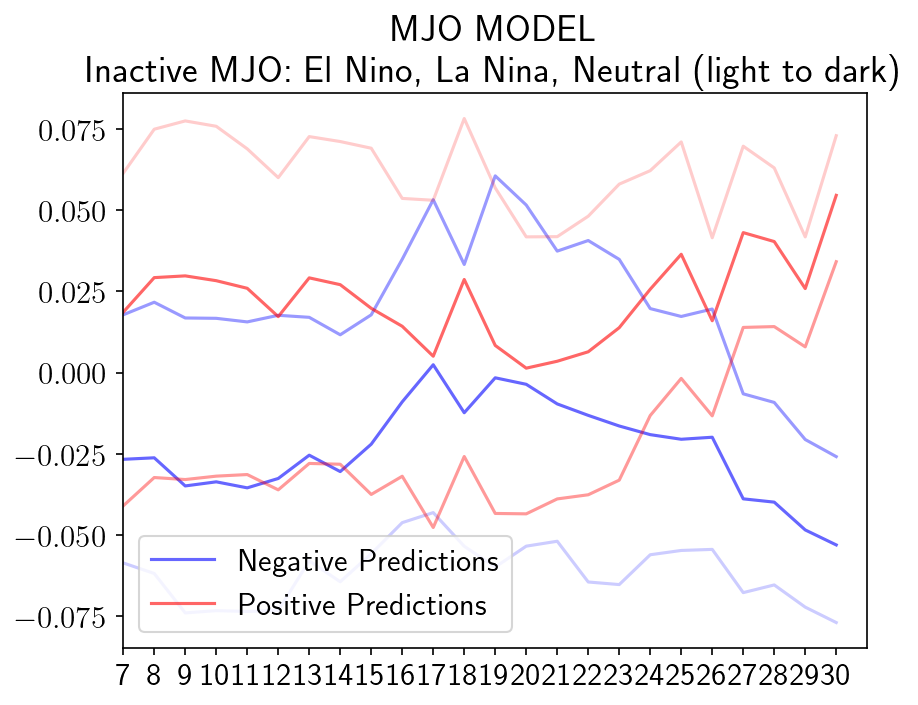

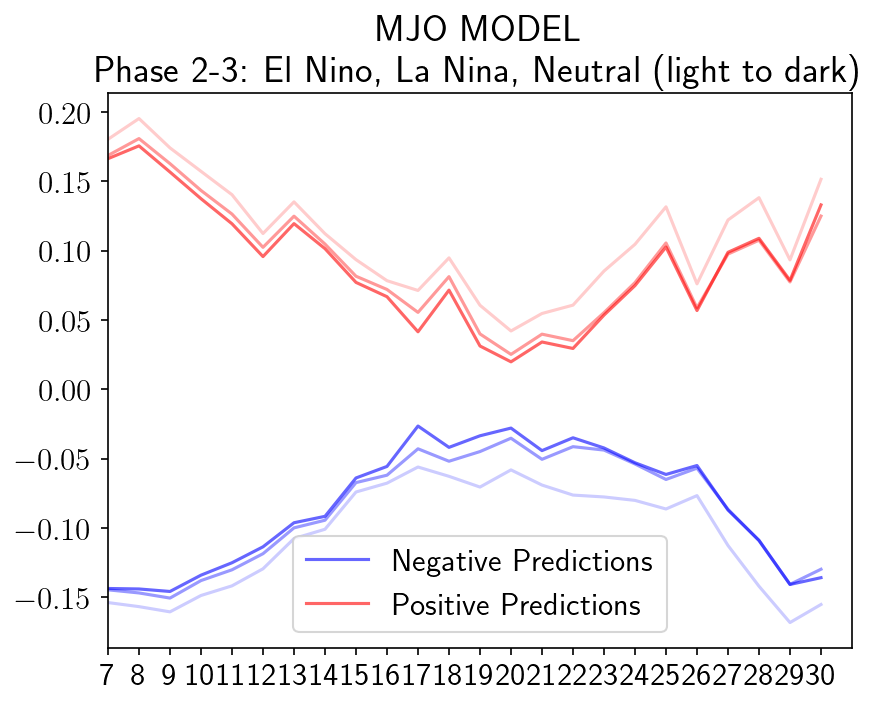

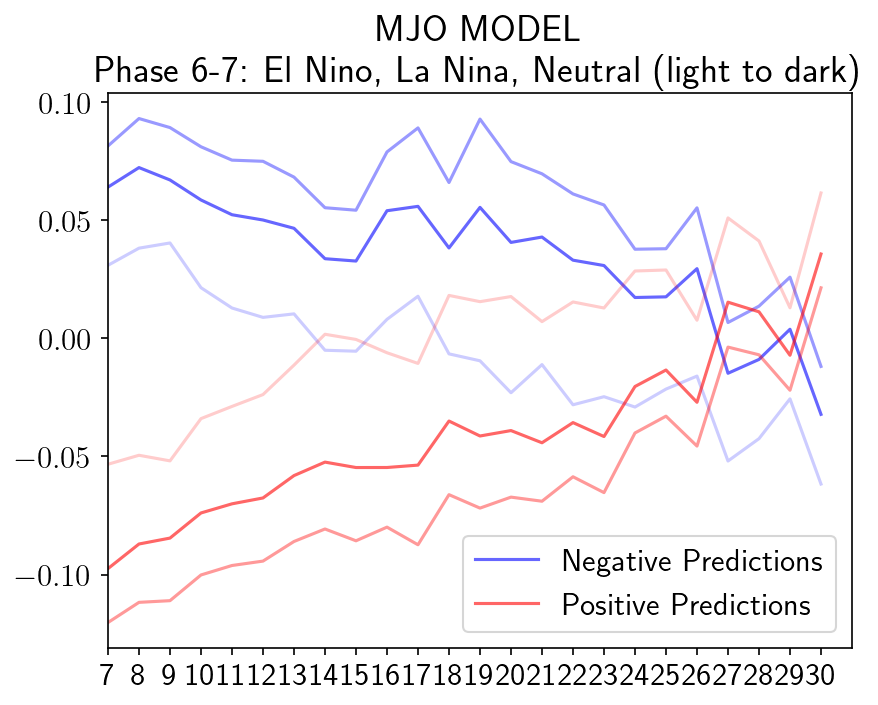

In [9]:
# El Nino negative predictions across leads
plt.plot(avg_inputweight[:,1,0,0],color='blue',alpha=0.2)
plt.plot(avg_inputweight[:,1,3,0],color='blue',alpha=0.4)
plt.plot(avg_inputweight[:,1,6,0],color='blue',alpha=0.6,label='Negative Predictions')

# El Nino positive predictions across leads
plt.plot(avg_inputweight[:,1,0,1],color='red',alpha=0.2)
plt.plot(avg_inputweight[:,1,3,1],color='red',alpha=0.4)
plt.plot(avg_inputweight[:,1,6,1],color='red',alpha=0.6,label='Positive Predictions')

plt.xlim(0,24)
plt.xticks(np.arange(0,24),np.arange(7,31))
plt.legend()
plt.title('MJO MODEL \n Inactive MJO: El Nino, La Nina, Neutral (light to dark)')
plt.show()


# La Nina negative predictions across leads
plt.plot(avg_inputweight[:,1,1,0],color='blue',alpha=0.2)
plt.plot(avg_inputweight[:,1,4,0],color='blue',alpha=0.4)
plt.plot(avg_inputweight[:,1,7,0],color='blue',alpha=0.6,label='Negative Predictions')

# La Nina positive predictions across leads
plt.plot(avg_inputweight[:,1,1,1],color='red',alpha=0.2)
plt.plot(avg_inputweight[:,1,4,1],color='red',alpha=0.4)
plt.plot(avg_inputweight[:,1,7,1],color='red',alpha=0.6,label='Positive Predictions')

plt.xlim(0,24)
plt.xticks(np.arange(0,24),np.arange(7,31))
plt.legend()
plt.title('MJO MODEL \n Phase 2-3: El Nino, La Nina, Neutral (light to dark)')
plt.show()

# Neutral negative predictions across leads
plt.plot(avg_inputweight[:,1,2,0],color='blue',alpha=0.2)
plt.plot(avg_inputweight[:,1,5,0],color='blue',alpha=0.4)
plt.plot(avg_inputweight[:,1,8,0],color='blue',alpha=0.6,label='Negative Predictions')

# Neutral positive predictions across leads
plt.plot(avg_inputweight[:,1,2,1],color='red',alpha=0.2)
plt.plot(avg_inputweight[:,1,5,1],color='red',alpha=0.4)
plt.plot(avg_inputweight[:,1,8,1],color='red',alpha=0.6,label='Positive Predictions')

plt.xlim(0,24)
plt.xticks(np.arange(0,24),np.arange(7,31))
plt.legend()
plt.title('MJO MODEL \n Phase 6-7: El Nino, La Nina, Neutral (light to dark)')
plt.show()